In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
file_path = 'data\csv\Prec 1993-2023.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])

In [3]:
data.set_index('Date', inplace=True)
data = data.sort_index()

In [4]:
data['precipitation'] = data['precipitation'].fillna(0)

In [5]:
def spi(ds, thresh):
    #Rolling Mean
    ds_ma = ds.rolling(window=thresh, min_periods=1, center=False).mean()

    # Replace zeros in rolling mean with a small value to avoid log issues
    epsilon = 1e-6  # Small value to substitute for zeros
    ds_ma_safe = ds_ma.replace(0, epsilon)
    
    #Nutural log of M. A.
    ds_In = np.log(ds_ma_safe)

    ds_mu = ds_ma.mean()

    #summation of log of M. A.
    ds_sum = ds_In.sum()

    #computing for gamma distribution
    n = len(ds_In)
    A = np.log(ds_mu) - (ds_sum/n)
    alpha = (1 / (4 * A) ) * (1 + (1 + (4 * A) / 3) ** 0.5)
    beta = ds_mu/alpha

    #gamm distribution (CDF)
    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta)

    #SPI (Inverse of CDF)
    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)

    return norm_spi

In [7]:
times = [3, 6, 9, 12]
for i in times:
    x = spi(data['precipitation'], i)
    data['spi_'+str(i)] = x

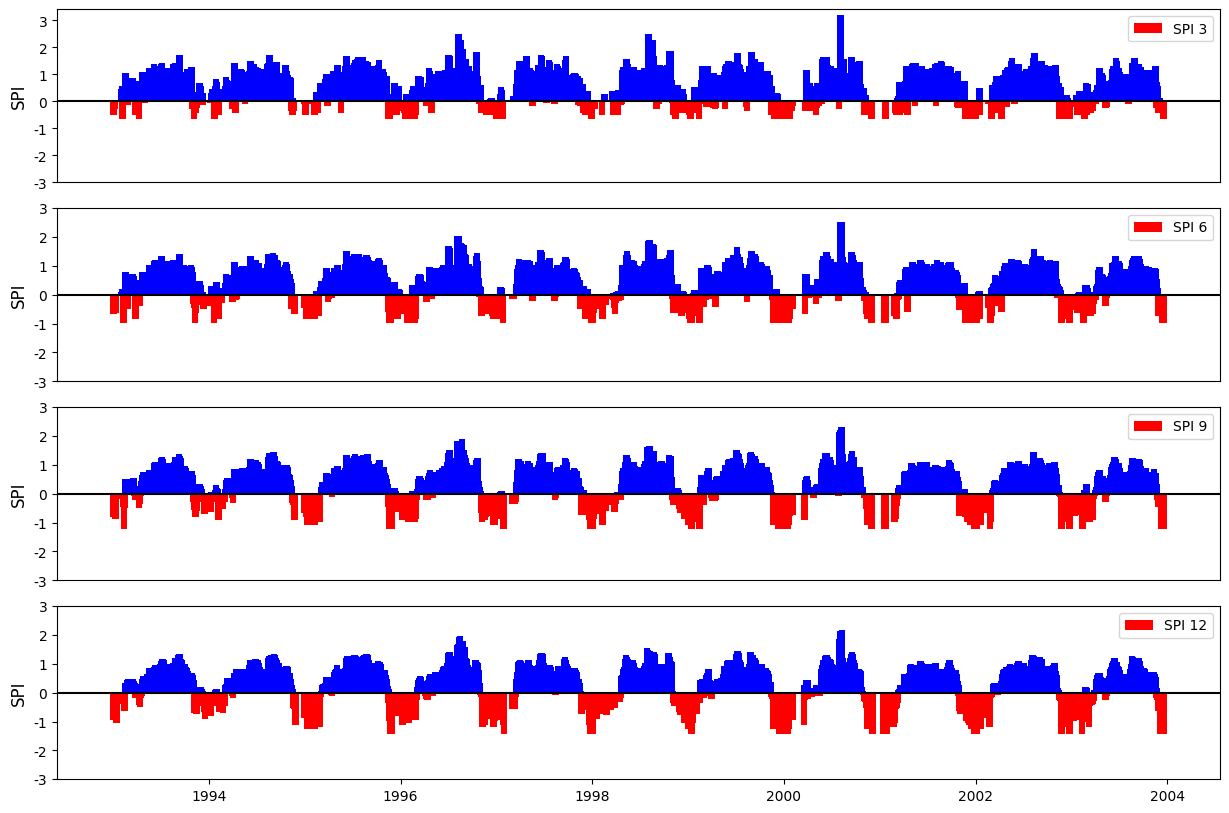

In [10]:
fig, axes = plt.subplots(nrows=4, figsize=(15, 10))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):
    col_scheme = np.where(data['spi_'+str(times[i])]>0, 'b', 'r')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data['spi_'+str(times[i])], width=25, align='center', color=col_scheme, label='SPI '+str(times[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI', fontsize=12)

    if i<len(times)-1:
        ax.set_xticks([], [])